###  Обучение логистической регрессии на полном датасете с выводом итоговых метрик

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import math

In [2]:
X = np.load('dog_features75.npy')  # Загрузка фичей
y = np.load('dog_labels75.npy')    # Загрузка меток

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Конвертация в тензоры
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.LongTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        return self.linear(x)

input_dim = X.shape[1]
output_dim = len(np.unique(y))
model = LogisticRegression(input_dim, output_dim)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

def calculate_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    return precision, recall, f1

best_f1 = 0
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    # Валидация
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        _, val_preds = torch.max(val_outputs, 1)
        
        val_loss = criterion(val_outputs, y_val_tensor)
        val_precision, val_recall, val_f1 = calculate_metrics(y_val_tensor.numpy(), val_preds.numpy())
        
        # Сохраняем лучшую модель
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), 'best_model_log_reg.pth')
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}')
        print(f'Val Precision: {val_precision:.4f} | Val Recall: {val_recall:.4f} | Val F1: {val_f1:.4f}\n')


Epoch [10/100]
Train Loss: 0.2974 | Val Loss: 0.6837
Val Precision: 0.8435 | Val Recall: 0.8314 | Val F1: 0.8273

Epoch [20/100]
Train Loss: 0.1645 | Val Loss: 0.6711
Val Precision: 0.8314 | Val Recall: 0.8215 | Val F1: 0.8179

Epoch [30/100]
Train Loss: 0.4734 | Val Loss: 0.6786
Val Precision: 0.8348 | Val Recall: 0.8261 | Val F1: 0.8223

Epoch [40/100]
Train Loss: 0.2248 | Val Loss: 0.6851
Val Precision: 0.8329 | Val Recall: 0.8235 | Val F1: 0.8209

Epoch [50/100]
Train Loss: 0.1835 | Val Loss: 0.6723
Val Precision: 0.8356 | Val Recall: 0.8287 | Val F1: 0.8265

Epoch [60/100]
Train Loss: 0.2848 | Val Loss: 0.6795
Val Precision: 0.8273 | Val Recall: 0.8202 | Val F1: 0.8172

Epoch [70/100]
Train Loss: 0.7193 | Val Loss: 0.6771
Val Precision: 0.8381 | Val Recall: 0.8300 | Val F1: 0.8269

Epoch [80/100]
Train Loss: 0.2226 | Val Loss: 0.6823
Val Precision: 0.8228 | Val Recall: 0.8155 | Val F1: 0.8128

Epoch [90/100]
Train Loss: 0.2793 | Val Loss: 0.6789
Val Precision: 0.8311 | Val Recall:

In [16]:
def plot_enhanced_confusion_matrix(y_true, y_pred, class_names, figsize=(20, 18), 
                                 font_scale=0.8, annot_fontsize=7, dpi=150):
    """
    Улучшенная визуализация confusion matrix с:
    - Автоматическим подбором размера шрифта
    - Четким разделением классов
    - Оптимизированным расположением элементов
    """
    # Создаем confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Настройка стиля
    sns.set(font_scale=font_scale)
    plt.figure(figsize=figsize, dpi=dpi)
    
    # Визуализация heatmap с улучшениями
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names,
                    yticklabels=class_names,
                    annot_kws={"size": annot_fontsize},
                    linewidths=0.5, linecolor='lightgray')
    
    # Улучшение подписей
    plt.title('Dog Breeds Classification Confusion Matrix\n', 
              pad=20, fontsize=14, fontweight='bold')
    plt.xlabel('\nPredicted Breed', labelpad=15, fontsize=12)
    plt.ylabel('Actual Breed\n', labelpad=15, fontsize=12)
    
    # Оптимизация меток
    ax.set_xticklabels(ax.get_xticklabels(), 
                      rotation=45, 
                      ha='right',
                      fontsize=annot_fontsize+1)
    ax.set_yticklabels(ax.get_yticklabels(), 
                      rotation=0, 
                      fontsize=annot_fontsize+1)
    
    # Добавление разделительных линий для групп классов
    for i in range(0, len(class_names)+1, 5):
        ax.axhline(i, color='gray', linewidth=0.5, linestyle='--')
        ax.axvline(i, color='gray', linewidth=0.5, linestyle='--')
    
    # Оптимизация расположения
    plt.tight_layout()
    
    # Сохранение с высоким качеством
    plt.savefig('dog_breeds_confusion_matrix.png', 
               dpi=dpi, 
               bbox_inches='tight',
               transparent=False)
    plt.show()
    plt.close()

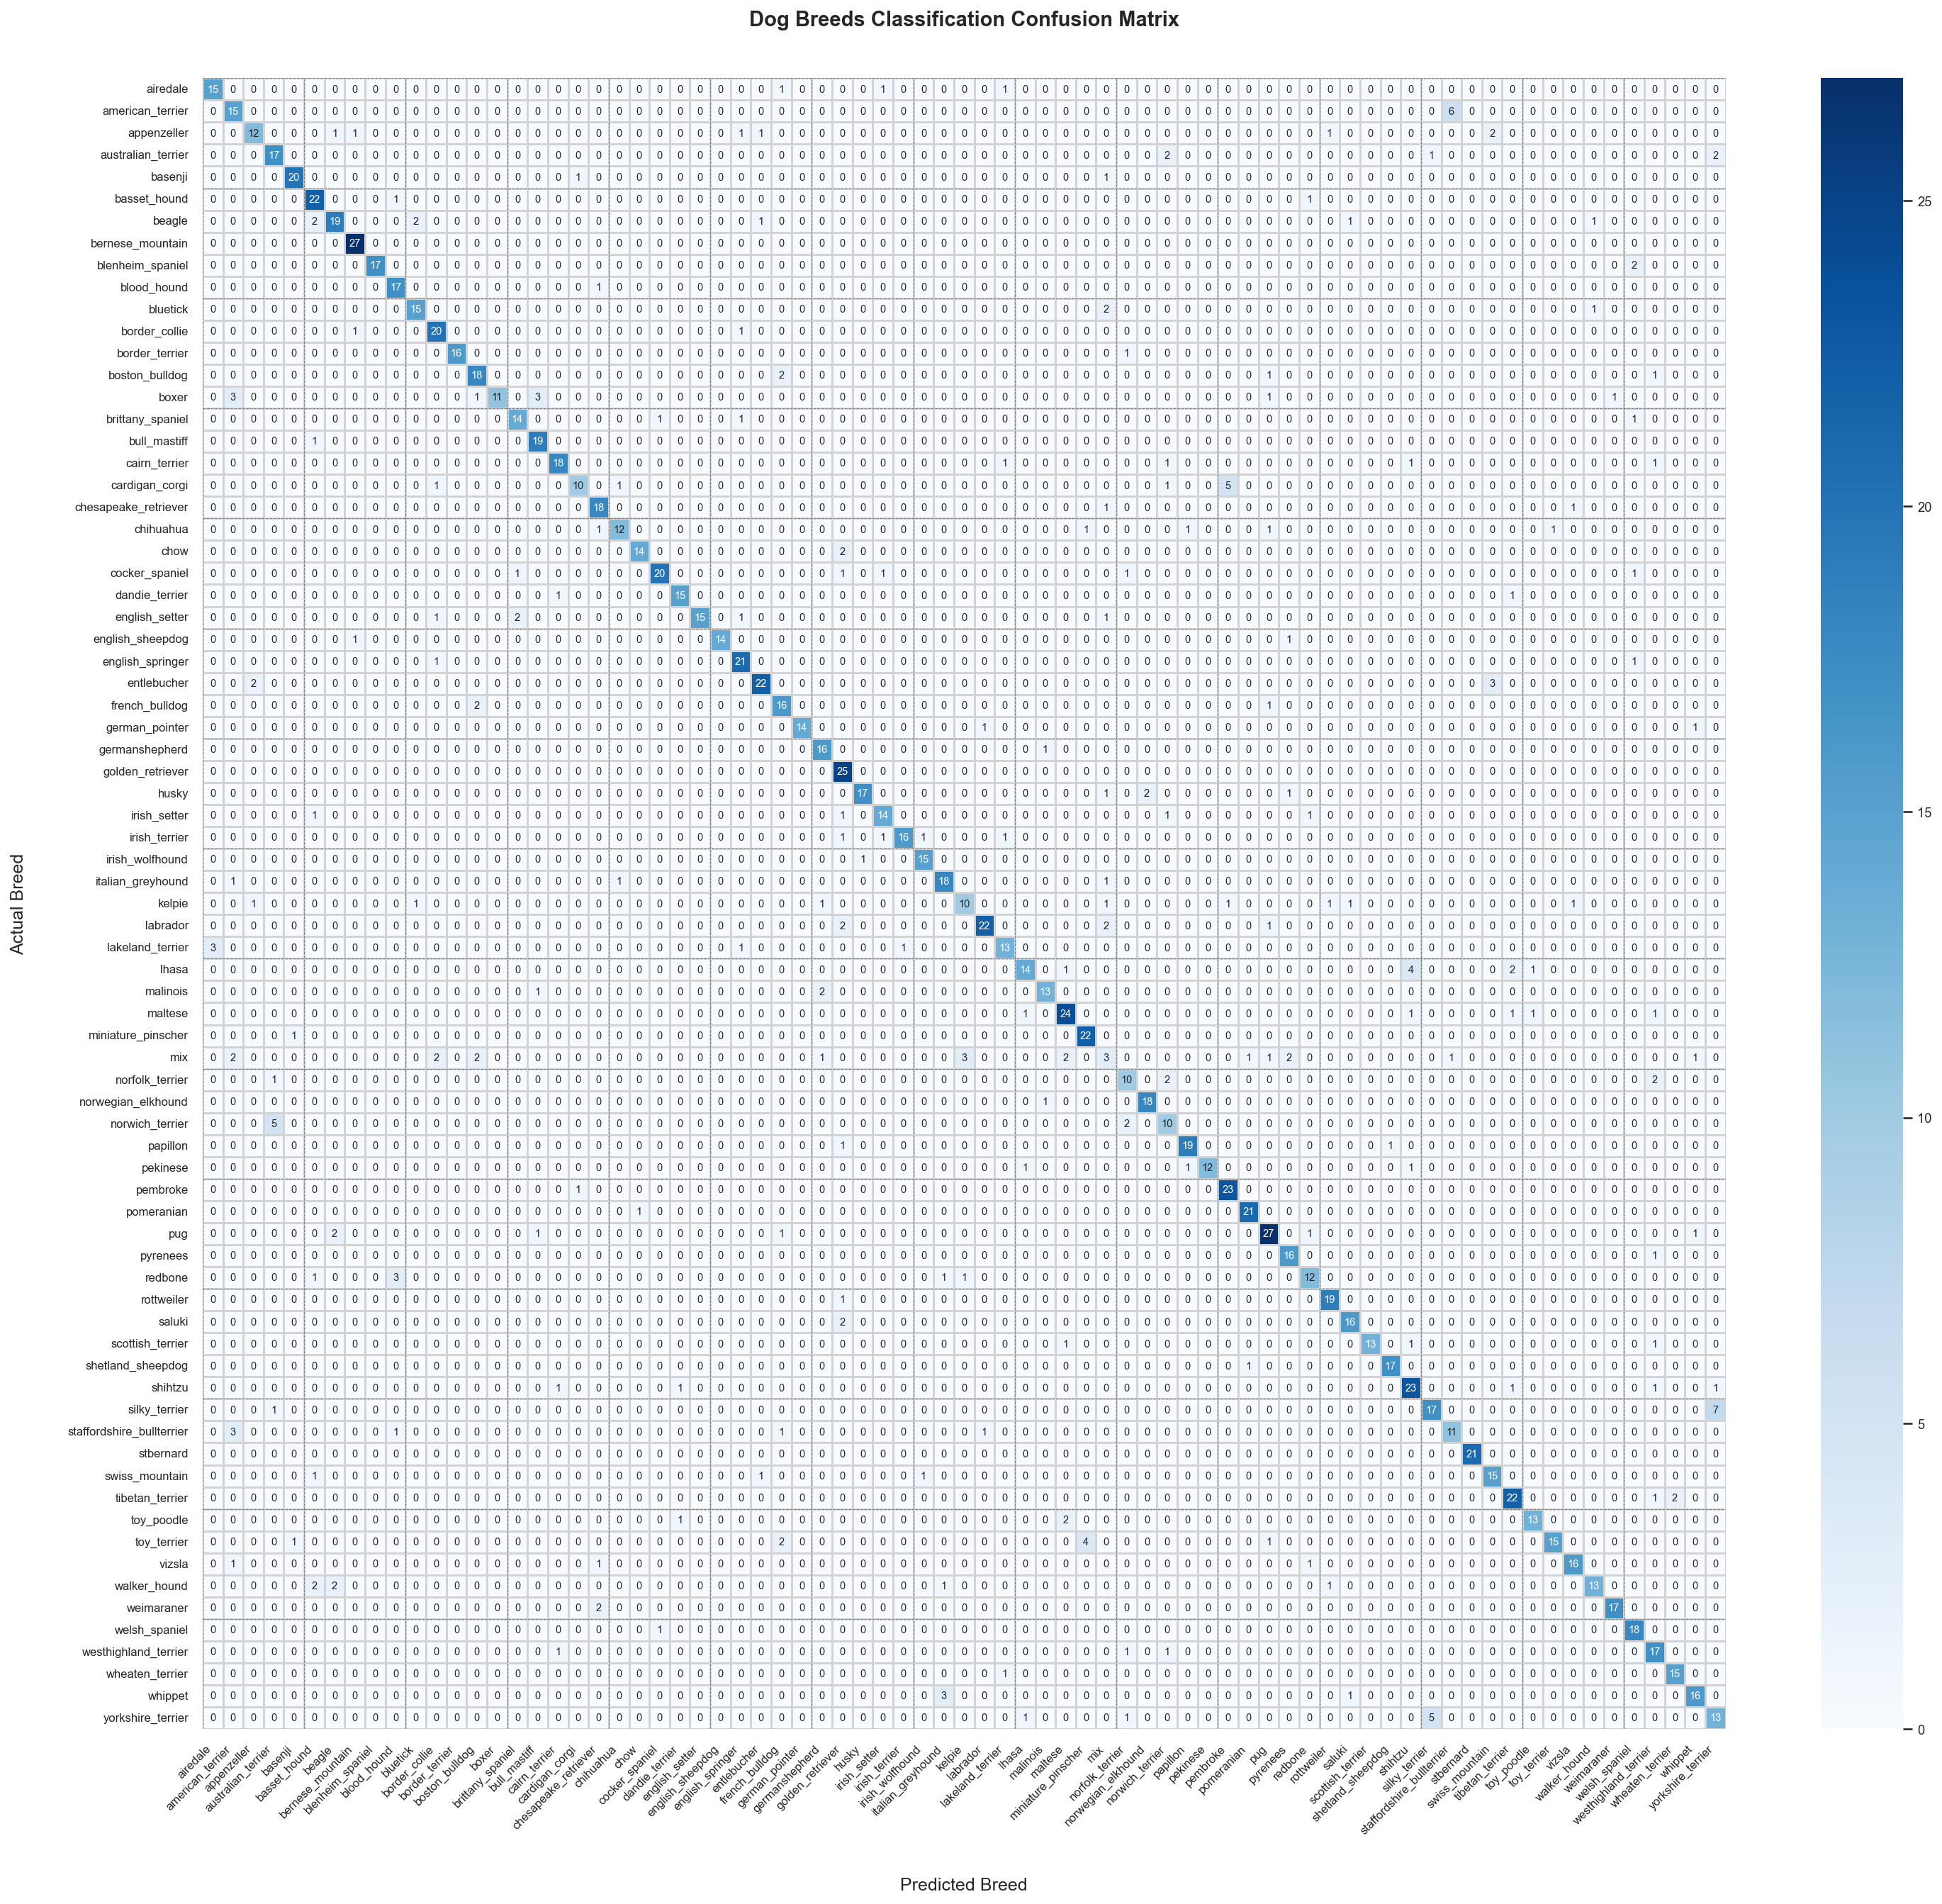


Final Test Metrics:
Accuracy: 0.8169
Precision: 0.8229
Recall: 0.8169
F1 Score: 0.8145



In [17]:
# Тестирование лучшей модели
model.load_state_dict(torch.load('best_model_log_reg.pth'))
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, test_preds = torch.max(test_outputs, 1)
    
    # Конвертируем тензоры в numpy
    y_test_np = y_test_tensor.numpy()
    test_preds_np = test_preds.numpy()
    
    test_precision, test_recall, test_f1 = calculate_metrics(y_test_np, test_preds_np)
    test_accuracy = (test_preds == y_test_tensor).float().mean()
    
    data_root = "C:/Users/User/.cache/kagglehub/datasets/darshanthakare/dog-breeds-image-dataset/versions/1/cropped_dogs"
    class_names = sorted(os.listdir(data_root))
        
    # Сonfusion matrix
    plot_enhanced_confusion_matrix(y_test_np, test_preds_np, class_names)

    print('\nFinal Test Metrics:')
    print(f'Accuracy: {test_accuracy:.4f}')
    print(f'Precision: {test_precision:.4f}')
    print(f'Recall: {test_recall:.4f}')
    print(f'F1 Score: {test_f1:.4f}\n')

#### ВЫВОД: Данная модель отлично справляется с многоклассовой классификацией благодаря CNN-фичам